### 2.3 Data Exploration

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev, count, when, to_date, concat, lit

spark = SparkSession.builder \
    .appName("PySpark") \
    .getOrCreate()

dch = spark.read.csv('Obesity_among_children_and_adolescents.csv', header=True, inferSchema=True)
dad = spark.read.csv('Normal_weight_overweight_and_obesity_among_adults.csv', header=True, inferSchema=True)  

Data $Obesity\_among\_children\_and\_adolescents$

In [ ]:
plt.figure(figsize=(6, 4))
dch_pd = dch.select('ESTIMATE', 'AGE').toPandas() 
sns.histplot(data=dch_pd, x='ESTIMATE', hue='AGE', palette='viridis', bins=25, multiple='stack', legend=True)
plt.title('Distribution of ESTIMATE by Age')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))
dch_sex_pd = dch.filter(col('STUB_NAME') == 'Sex').select('ESTIMATE', 'STUB_LABEL').toPandas()
sns.histplot(data=dch_sex_pd, x='ESTIMATE', hue='STUB_LABEL', palette='viridis', bins=25, multiple='stack', legend=True)
plt.title('Distribution of ESTIMATE by Sex')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

Data $Normal\_weight\_overweight\_and\_obesity\_among\_adults$

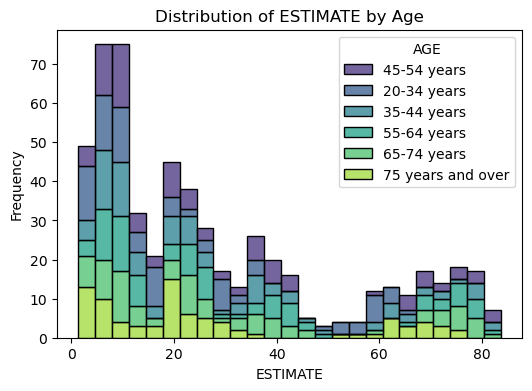

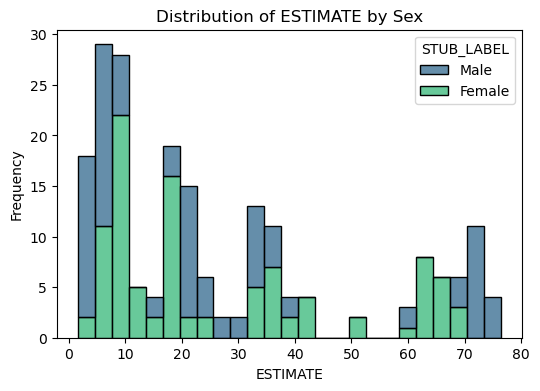

In [40]:
dad_ob = dad.filter(col('PANEL') != "Normal weight (BMI from 18.5 to 24.9)")
dad_age = dad_ob.filter(col('AGE') != "20 years and over")
dad_age_pd = dad_age.select('ESTIMATE', 'AGE').toPandas()
plt.figure(figsize=(6, 4))
sns.histplot(data=dad_age_pd, x='ESTIMATE', hue='AGE', palette='viridis', bins=25, multiple='stack', legend=True)
plt.title('Distribution of ESTIMATE by Age')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

dad_sex = dad_ob.filter(col('STUB_NAME') == 'Sex')
dad_sex_pd = dad_sex.select('ESTIMATE', 'STUB_LABEL').toPandas()
plt.figure(figsize=(6, 4))
sns.histplot(data=dad_sex_pd, x='ESTIMATE', hue='STUB_LABEL', palette='viridis', bins=25, multiple='stack', legend=True)
plt.title('Distribution of ESTIMATE by Sex')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

### 2.4 Verifying Data Quality
Data $Obesity\_among\_children\_and\_adolescents$


Types and Completeness in each column:
                    Data Type  Completeness(%)  Valid Records  Null Values
INDICATOR        StringType()       100.000000            840            0
PANEL            StringType()       100.000000            840            0
PANEL_NUM       IntegerType()       100.000000            840            0
UNIT             StringType()       100.000000            840            0
UNIT_NUM        IntegerType()       100.000000            840            0
STUB_NAME        StringType()       100.000000            840            0
STUB_NAME_NUM   IntegerType()       100.000000            840            0
STUB_LABEL_NUM   DoubleType()        95.000000            800           40
STUB_LABEL       StringType()       100.000000            840            0
YEAR             StringType()       100.000000            840            0
YEAR_NUM        IntegerType()       100.000000            840            0
AGE              StringType()       100.000000            84

/var/folders/24/98z0643n2434n2thw1yzm29h0000gn/T/ipykernel_14933/3226634463.py:36: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dch_pd, x='ESTIMATE', palette='viridis', bins=25)


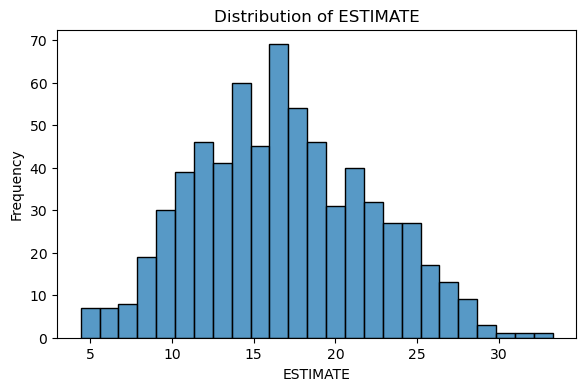

In [41]:
completeness = dch.select([(1 - (count(when(col(c).isNull(), c)) / count(c))).alias(c) for c in dch.columns]).first().asDict()
valid_records = dch.agg(*(count(col(c)).alias(c) for c in dch.columns)).first().asDict()
null_values = {col: dch.count() - valid_records[col] for col in valid_records}

column_info = pd.DataFrame({
    'Data Type': [dch.schema[col].dataType for col in dch.columns],
    'Completeness(%)': [completeness[col] * 100 for col in dch.columns],
    'Valid Records': [valid_records[col] for col in dch.columns],
    'Null Values': [null_values[col] for col in dch.columns]
}, index=dch.columns)

print("\nTypes and Completeness in each column:")
print(column_info)

def detect_outliers_extremes(df, column, threshold=3):
    stats = df.select(mean(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).first()
    mean_val = stats['mean']
    std_dev = stats['stddev']
    
    lower_threshold = mean_val - threshold * std_dev
    upper_threshold = mean_val + threshold * std_dev
    
    outliers = df.filter((col(column) < lower_threshold) | (col(column) > upper_threshold))
    
    return outliers.select(col(column)).collect()

outliers_estimate = detect_outliers_extremes(dch, 'ESTIMATE')
outliers_se = detect_outliers_extremes(dch, 'SE')

print("\n")
print(f"Outliers in column ESTIMATE: {[row.ESTIMATE for row in outliers_estimate]}")
print(f"Outliers in column SE: {[row.SE for row in outliers_se]}")

dch_pd = dch.select('ESTIMATE').toPandas()
plt.figure(figsize=(6.7, 4))
sns.histplot(data=dch_pd, x='ESTIMATE', palette='viridis', bins=25)
plt.title('Distribution of ESTIMATE')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

Data $Normal\_weight\_overweight\_and\_obesity\_among\_adults$

Shape of the dataset: (3360, 16)

Columns in the dataset:  ['INDICATOR', 'PANEL', 'PANEL_NUM', 'UNIT', 'UNIT_NUM', 'STUB_NAME', 'STUB_NAME_NUM', 'STUB_LABEL', 'STUB_LABEL_NUM', 'YEAR', 'YEAR_NUM', 'AGE', 'AGE_NUM', 'ESTIMATE', 'SE', 'FLAG']

Types and Completeness in each column:
                    Data Type  Completeness(%)  Valid Records  Null Values
INDICATOR        StringType()       100.000000           3360            0
PANEL            StringType()       100.000000           3360            0
PANEL_NUM       IntegerType()       100.000000           3360            0
UNIT             StringType()       100.000000           3360            0
UNIT_NUM        IntegerType()       100.000000           3360            0
STUB_NAME        StringType()       100.000000           3360            0
STUB_NAME_NUM   IntegerType()       100.000000           3360            0
STUB_LABEL       StringType()       100.000000           3360            0
STUB_LABEL_NUM   DoubleType()       100.0000

/var/folders/24/98z0643n2434n2thw1yzm29h0000gn/T/ipykernel_14933/1561855619.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dad_pd, x='ESTIMATE', palette='viridis', bins=25)


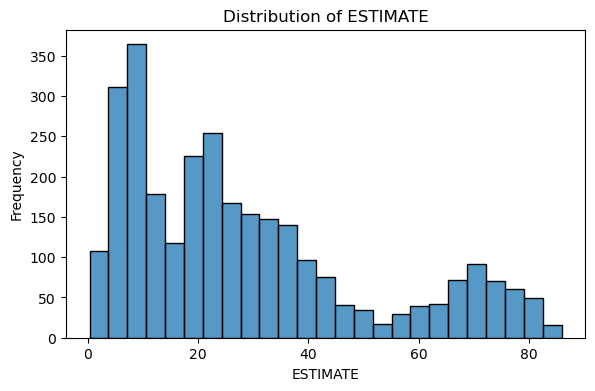

In [42]:
print("Shape of the dataset:", (dad.count(), len(dad.columns)))
print("\nColumns in the dataset: ", dad.columns)

# Types and Completeness
completeness = dad.select([(1 - (count(when(col(c).isNull(), c)) / count(c))).alias(c) for c in dad.columns]).first().asDict()
valid_records = dad.select([count(col(c)).alias(c) for c in dad.columns]).first().asDict()
null_values = {col: dad.count() - valid_records[col] for col in valid_records}

column_info = pd.DataFrame({
    'Data Type': [dad.schema[col].dataType for col in dad.columns],
    'Completeness(%)': [completeness[col] * 100 for col in dad.columns],
    'Valid Records': [valid_records[col] for col in dad.columns],
    'Null Values': [null_values[col] for col in dad.columns]
}, index=dad.columns)

print("\nTypes and Completeness in each column:")
print(column_info)

# Detect outliers and extremes
def detect_outliers_extremes(df, column, threshold=3):
    # Values beyond 3 standard deviations from the mean
    
    stats = df.select(mean(col(column)).alias('mean'), stddev(col(column)).alias('stddev')).first()
    mean_val = stats['mean']
    std_dev = stats['stddev']
    
    lower_threshold = mean_val - threshold * std_dev
    upper_threshold = mean_val + threshold * std_dev
    
    outliers = df.filter((col(column) < lower_threshold) | (col(column) > upper_threshold))
    
    return outliers.select(col(column)).collect()

outliers_estimate = detect_outliers_extremes(dad, 'ESTIMATE')
outliers_se = detect_outliers_extremes(dad, 'SE')

print("\n")
print(f"Outliers in column ESTIMATE: {[row['ESTIMATE'] for row in outliers_estimate]}")
print(f"Outliers in column SE: {[row['SE'] for row in outliers_se]}")

# Visualize the distribution of ESTIMATE
dad_pd = dad.select('ESTIMATE').toPandas()
plt.figure(figsize=(6.7, 4))
sns.histplot(data=dad_pd, x='ESTIMATE', palette='viridis', bins=25)
plt.title('Distribution of ESTIMATE')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

### 3.2 Data Cleaning
Data $Obesity\_among\_children\_and\_adolescents$

In [43]:
spark = SparkSession.builder \
    .appName("Data Cleaning") \
    .getOrCreate()

# Missings, outliers
pre_dch = dch.dropna(subset=['ESTIMATE', 'STUB_LABEL_NUM'])  
pre_dch = pre_dch.filter(col('SE') != 4.5)

# Irrelevant Features/Records and Duplicates
pre_dch = pre_dch.drop('PANEL_NUM', 'UNIT_NUM', 'STUB_NAME_NUM', 'STUB_LABEL_NUM', 'YEAR_NUM', 'AGE_NUM', 'FLAG')
pre_dch = pre_dch.dropDuplicates()

# Check cleaned data shape
shape = (pre_dch.count(), len(pre_dch.columns))
print("Shape of the cleaned dataset:", shape)

24/05/24 11:19:12 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Shape of the cleaned dataset: (632, 9)


Data $Normal\_weight\_overweight\_and\_obesity\_among\_adults$

In [44]:
# Missings, outliers
pre_dad = dad_ob.dropna(subset=['ESTIMATE', 'STUB_LABEL_NUM'])

# Irrelevant Features/Records and Duplicates
pre_dad = pre_dad.drop('PANEL_NUM', 'UNIT_NUM', 'STUB_NAME_NUM', 'STUB_LABEL_NUM', 'YEAR_NUM', 'AGE_NUM', 'FLAG')
pre_dad = pre_dad.dropDuplicates()

# Check cleaned data shape
shape = (pre_dad.count(), len(pre_dad.columns))
print("Shape of the cleaned dataset:", shape)

Shape of the cleaned dataset: (2411, 9)


### 3.3 Data Integration

In [45]:
pre_data = pre_dch.unionByName(pre_dad)

shape = (pre_data.count(), len(pre_data.columns))
print("Shape of the concatenated dataset:", shape)

Shape of the concatenated dataset: (3043, 9)


### 3.4 Constructing/Deriving a New Feature

In [46]:
from pyspark.sql.types import BooleanType
pre_data = pre_data.withColumnRenamed('PANEL', 'INFO')
pre_data = pre_data.withColumn('YEAR_proxy', to_date(col('YEAR').substr(1, 4), 'yyyy'))
pre_data = pre_data.withColumn('STUB_LABEL_Derive', concat(col('STUB_NAME'), lit(': '), col('STUB_LABEL')))
pre_data = pre_data.withColumn('IS_ADULT', when(col('INDICATOR') == 'Normal weight, overweight, and obesity among adults aged 20 and over', True).otherwise(False).cast(BooleanType()))

### 3.5 Formatting Data

In [47]:
pre_data = pre_data.drop('INDICATOR', 'STUB_NAME', 'STUB_LABEL', 'SE')

category_columns = ['INFO', 'YEAR_proxy', 'STUB_LABEL_Derive', 'IS_ADULT']
for column in category_columns:
    pre_data = pre_data.withColumn(column, col(column).cast('string'))

pre_data.write.csv('prepared_data.csv', header=True, mode='overwrite')

pre_data.printSchema()

root
 |-- INFO: string (nullable = true)
 |-- UNIT: string (nullable = true)
 |-- YEAR: string (nullable = true)
 |-- AGE: string (nullable = true)
 |-- ESTIMATE: double (nullable = true)
 |-- YEAR_proxy: string (nullable = true)
 |-- STUB_LABEL_Derive: string (nullable = true)
 |-- IS_ADULT: string (nullable = false)



## 4.1 Data Reducion

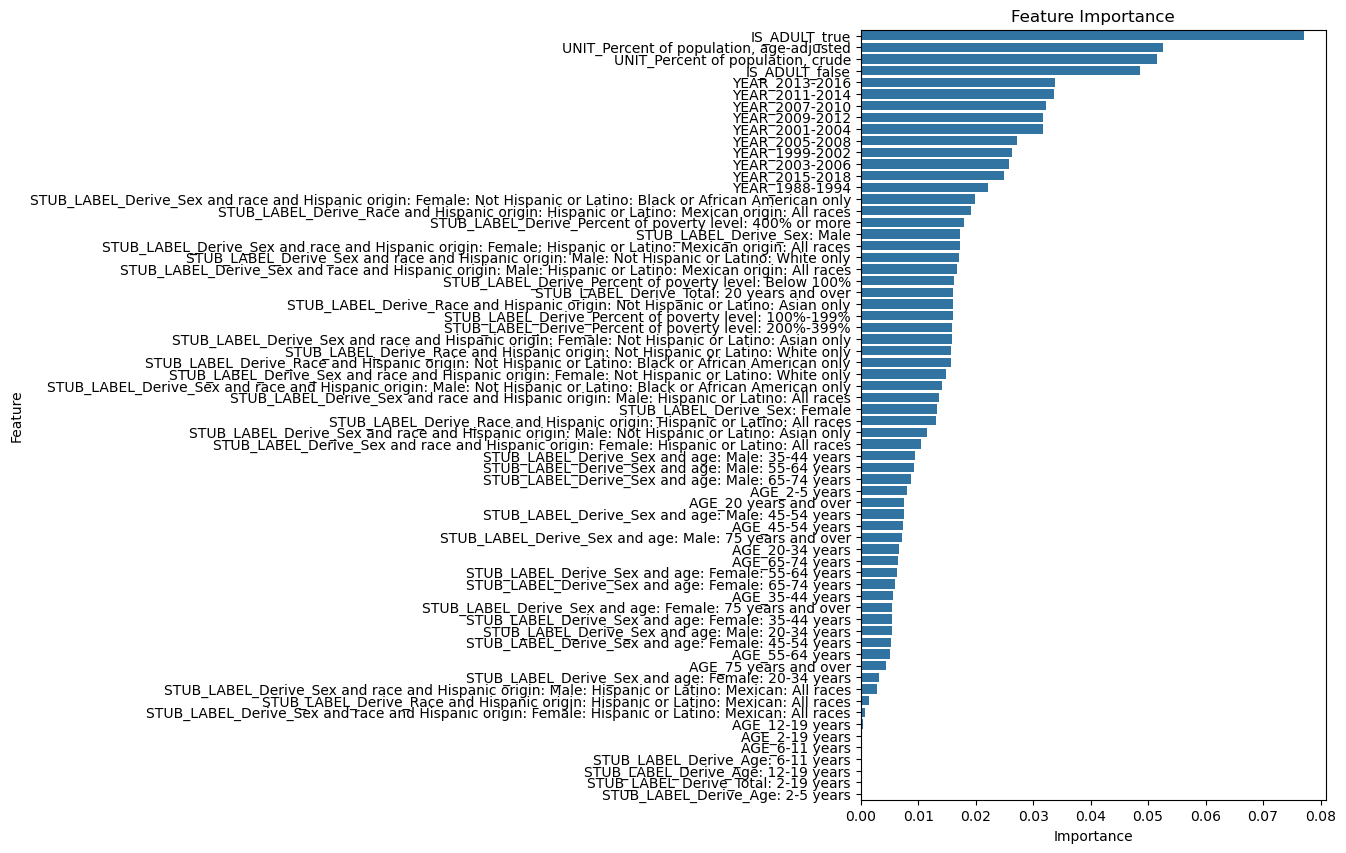

In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

pre_data = pre_data.toPandas()
features = pre_data.drop(['ESTIMATE', 'YEAR_proxy','INFO'], axis=1) 
features_encoded = pd.get_dummies(features)

target = pre_data['ESTIMATE']

X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features_encoded.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#print(feature_importance_df)
plt.figure(figsize=(6, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

## 4.2 Data Projection

/var/folders/24/98z0643n2434n2thw1yzm29h0000gn/T/ipykernel_14933/2414055.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=pre_data, x='ESTIMATE', palette='viridis',bins=25)


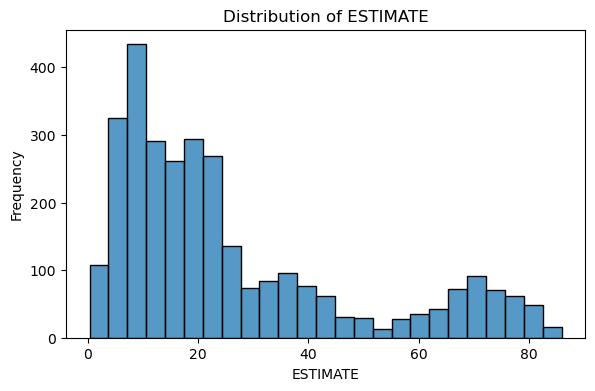

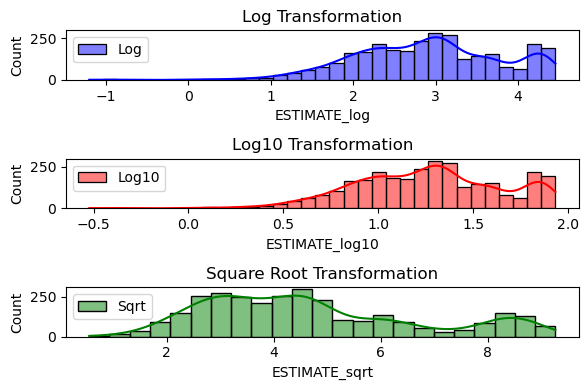

In [57]:
pre_data['ESTIMATE_log'] = np.log(pre_data['ESTIMATE'])
pre_data['ESTIMATE_log10'] = np.log10(pre_data['ESTIMATE'])
pre_data['ESTIMATE_sqrt'] = np.sqrt(pre_data['ESTIMATE'])

plt.figure(figsize=(6.7, 4))
sns.histplot(data=pre_data, x='ESTIMATE', palette='viridis',bins=25)
plt.title('Distribution of ESTIMATE')
plt.xlabel('ESTIMATE')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(6, 4))

plt.subplot(3, 1, 1)
sns.histplot(pre_data['ESTIMATE_log'], kde=True, label='Log', color='blue', alpha=0.5)
plt.title('Log Transformation')
plt.legend()

plt.subplot(3, 1, 2)
sns.histplot(pre_data['ESTIMATE_log10'], kde=True, label='Log10', color='red', alpha=0.5)
plt.title('Log10 Transformation')
plt.legend()

plt.subplot(3, 1, 3)
sns.histplot(pre_data['ESTIMATE_sqrt'], kde=True, label='Sqrt', color='green', alpha=0.5)
plt.title('Square Root Transformation')
plt.legend()

plt.tight_layout()
plt.show()

pre_data = pre_data.drop(columns=['ESTIMATE_log','ESTIMATE_log10'])
pre_data.to_csv('transformed_data.csv', index=False)


## 6.3 Build/Select Model with Algorithm/Model Parameters

In [58]:
import warnings
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

ts_data = pre_data.groupby('YEAR_proxy')['ESTIMATE_sqrt'].mean().reset_index()
ts_data.set_index('YEAR_proxy', inplace=True)  

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

warnings.filterwarnings("ignore")
for params in pdq:
    try:
        model = ARIMA(ts_data, order=params)
        results = model.fit()
        print('ARIMA{} - AIC:{}'.format(params, results.aic))
    except:
        continue
warnings.resetwarnings()

ARIMA(0, 0, 0) - AIC:3.9773219649667713
ARIMA(0, 0, 1) - AIC:3.2003999940000636
ARIMA(0, 0, 2) - AIC:3.253714726993329
ARIMA(0, 1, 0) - AIC:-3.363875885466949
ARIMA(0, 1, 1) - AIC:-1.9465297799470411
ARIMA(0, 1, 2) - AIC:-0.9922184330469141
ARIMA(0, 2, 0) - AIC:-3.7638801514346376
ARIMA(0, 2, 1) - AIC:-1.8355154954816948
ARIMA(0, 2, 2) - AIC:0.15379480563733594
ARIMA(1, 0, 0) - AIC:1.1024591646319521
ARIMA(1, 0, 1) - AIC:2.746820034361167
ARIMA(1, 0, 2) - AIC:4.050533579091091
ARIMA(1, 1, 0) - AIC:-2.401143235367589
ARIMA(1, 1, 1) - AIC:-0.6349442978469577
ARIMA(1, 1, 2) - AIC:1.006721576124269
ARIMA(1, 2, 0) - AIC:-1.8146069314764945
ARIMA(1, 2, 1) - AIC:0.1568557548754157
ARIMA(1, 2, 2) - AIC:2.1538304764761342
ARIMA(2, 0, 0) - AIC:2.516843105581427
ARIMA(2, 0, 1) - AIC:3.119034300569629
ARIMA(2, 0, 2) - AIC:6.050876725783709
ARIMA(2, 1, 0) - AIC:-0.5016234682781402
ARIMA(2, 1, 1) - AIC:1.3457974824282841
ARIMA(2, 1, 2) - AIC:3.3567378516875843
ARIMA(2, 2, 0) - AIC:0.1586962553251645

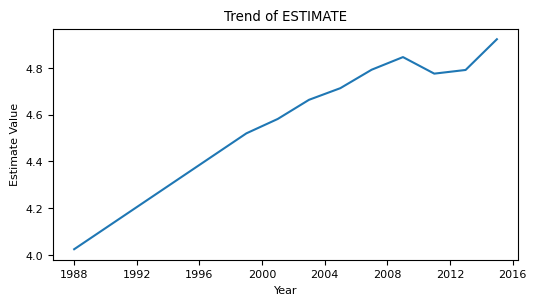

Selected variables: ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.679283580379873
Selected variables: ['YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.6793109785076816
Selected variables: ['UNIT', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.7475057275080474
Selected variables: ['UNIT', 'YEAR', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.7067408633711665
Selected variables: ['UNIT', 'YEAR', 'AGE', 'IS_ADULT']
Mean Squared Error: 3.8528003948181624
Selected variables: ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive']
Mean Squared Error: 3.679283670900506
Selected variables: ['AGE', 'YEAR', 'STUB_LABEL_Derive']
Mean Squared Error: 3.679305714183568


In [512]:
plt.figure(figsize=(6, 3))
plt.plot(ts_data['ESTIMATE_sqrt'])
plt.title('Trend of ESTIMATE')
plt.xlabel('Year')
plt.ylabel('Estimate Value')
plt.show()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

pre_data_ln = pre_data
pre_data_ln['YEAR'] = pd.to_datetime(pre_data['YEAR_proxy']).dt.year
pre_data_ln = pre_data_ln.drop(columns=['ESTIMATE','INFO','YEAR_proxy']) 

def diff_set(data, variables):
   variables.append('ESTIMATE_sqrt')
   data = data[variables]
   X = data.drop(columns=['ESTIMATE_sqrt']) 
   X = pd.get_dummies(X)
   y = data['ESTIMATE_sqrt']

   model = LinearRegression()
   model.fit(X, y)
   y_pred = model.predict(X)

   mse = mean_squared_error(y, y_pred)
   print("Mean Squared Error:", mse)

variable_sets = [
    ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT'], # whole variables
    ['YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT'],
    ['UNIT', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT'],
    ['UNIT', 'YEAR', 'STUB_LABEL_Derive', 'IS_ADULT'],
    ['UNIT', 'YEAR', 'AGE', 'IS_ADULT'],
    ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive'],
    ['AGE', 'YEAR', 'STUB_LABEL_Derive'],
]

for selected_variables in variable_sets:
    print(f"Selected variables: {selected_variables}")
    diff_set(pre_data, selected_variables)


warnings.resetwarnings()

In [513]:
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

def diff_set(data, variables):
   variables.append('ESTIMATE_sqrt')
   data = data[variables]
   X = data.drop(columns=['ESTIMATE_sqrt']) 
   X = pd.get_dummies(X)
   y = data['ESTIMATE_sqrt']
   X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25) #split

   model = LinearRegression()
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)

   mse = mean_squared_error(y_test, y_pred)
   print("Mean Squared Error:", mse)

variable_sets = [
    ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT'], # whole variables
    ['YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT'],
    ['UNIT', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT'],
    ['UNIT', 'YEAR', 'STUB_LABEL_Derive', 'IS_ADULT'],
    ['UNIT', 'YEAR', 'AGE', 'IS_ADULT'],
    ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive'],
    ['AGE', 'YEAR', 'STUB_LABEL_Derive'],
]

for selected_variables in variable_sets:
    print(f"Selected variables: {selected_variables}")
    diff_set(pre_data, selected_variables)

warnings.resetwarnings()

Selected variables: ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.667232636063257
Selected variables: ['YEAR', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.669769962189021
Selected variables: ['UNIT', 'AGE', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.853270890395544
Selected variables: ['UNIT', 'YEAR', 'STUB_LABEL_Derive', 'IS_ADULT']
Mean Squared Error: 3.695458345219914
Selected variables: ['UNIT', 'YEAR', 'AGE', 'IS_ADULT']
Mean Squared Error: 3.7707450989736837
Selected variables: ['UNIT', 'YEAR', 'AGE', 'STUB_LABEL_Derive']
Mean Squared Error: 3.6671907845087506
Selected variables: ['AGE', 'YEAR', 'STUB_LABEL_Derive']
Mean Squared Error: 3.66704129920052


## 7.1 Creating Logical Tests

<Figure size 800x300 with 0 Axes>

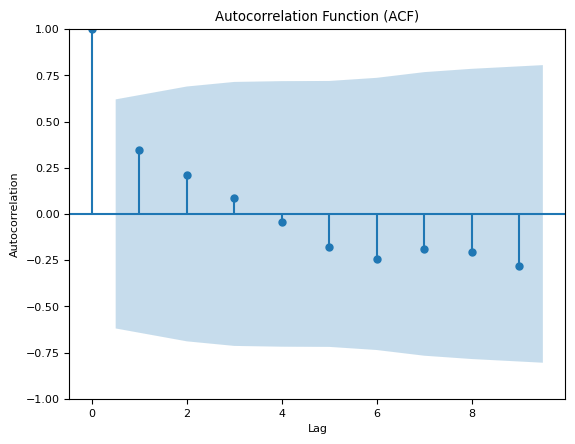

In [514]:
from statsmodels.graphics.tsaplots import plot_acf
ts_test_data = pre_data.groupby('YEAR_proxy')['ESTIMATE_sqrt'].mean().reset_index()
time_series = pd.Series(ts_test_data['ESTIMATE_sqrt'].values, index=pd.to_datetime(ts_test_data['YEAR_proxy']))

# ACF
plt.figure(figsize=(8, 3))
plot_acf(time_series, lags=9) 
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

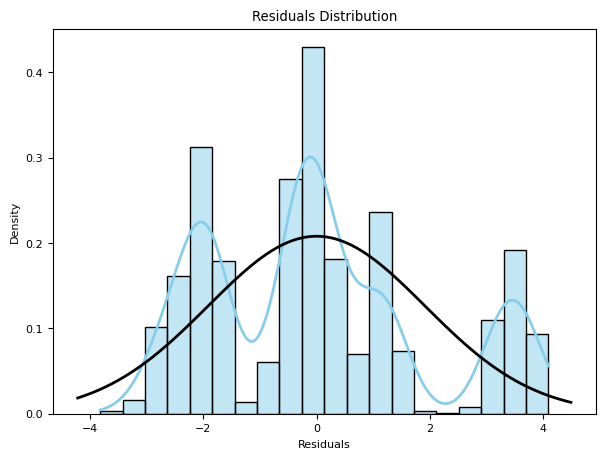

In [515]:
from scipy import stats
warnings.filterwarnings("ignore")
X = pre_data_ln.drop(columns=['ESTIMATE_sqrt']) 
X = pd.get_dummies(X)
y = pre_data_ln['ESTIMATE_sqrt']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
residuals = y - y_pred

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, stat='density', color='skyblue', line_kws={'linewidth': 2})
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)

plt.show()
warnings.resetwarnings()

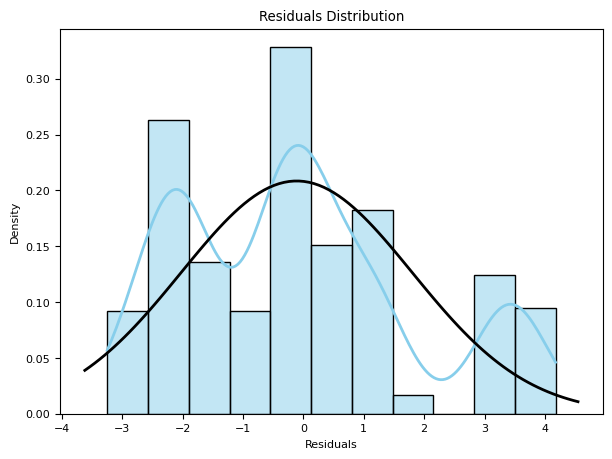

In [516]:
warnings.filterwarnings("ignore")
X = pre_data_ln.drop(columns=['ESTIMATE_sqrt','UNIT','IS_ADULT']) 
X = pd.get_dummies(X)
y = pre_data_ln['ESTIMATE_sqrt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25) #split

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
sns.histplot(residuals, kde=True, stat='density', color='skyblue', line_kws={'linewidth': 2})
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuals.mean(), residuals.std())
plt.plot(x, p, 'k', linewidth=2)

plt.show()
warnings.resetwarnings()

## 7.2 Conducting Data Mining

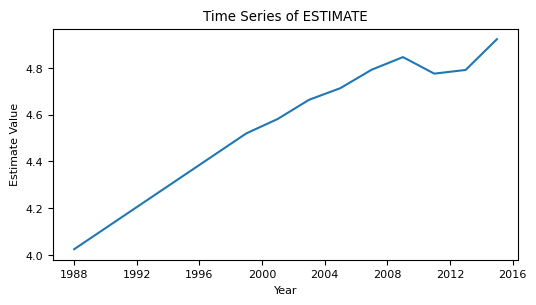

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


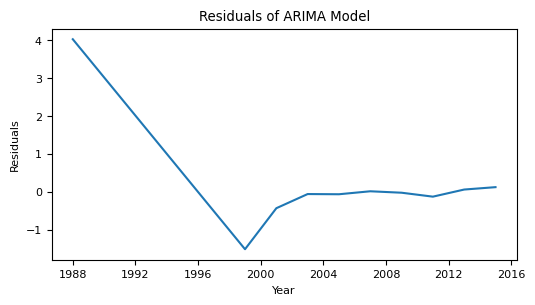

In [517]:
plt.figure(figsize=(6, 3))
plt.plot(ts_data['ESTIMATE_sqrt'])
plt.title('Time Series of ESTIMATE')
plt.xlabel('Year')
plt.ylabel('Estimate Value')
plt.show()

model = ARIMA(ts_data['ESTIMATE_sqrt'], order=(0, 2, 2)) 
model_fit = model.fit()
ts_info = model_fit.summary()

residuals = model_fit.resid
plt.figure(figsize=(6, 3))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.show()


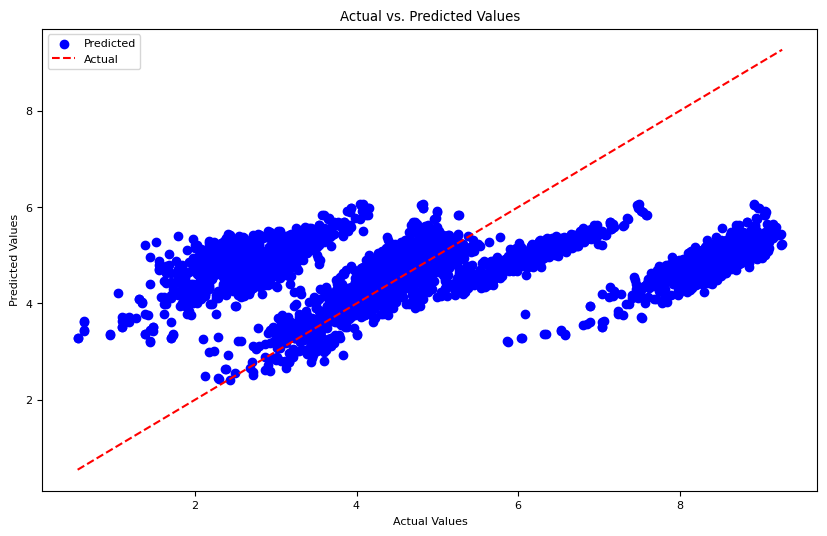

In [518]:
warnings.filterwarnings("ignore")
X = pre_data_ln.drop(columns=['ESTIMATE_sqrt']) 
X = pd.get_dummies(X)
y = pre_data_ln['ESTIMATE_sqrt']

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
md_cha = model

# visualize
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted')  
plt.plot([y.min(), y.max()], [y.min(), y.max()], linestyle='--', color='red', label='Actual')  
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

#model info
ln_cha_coeff = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
ln_cha_inter = model.intercept_
ln_cha_r2 = model.score(X, y)

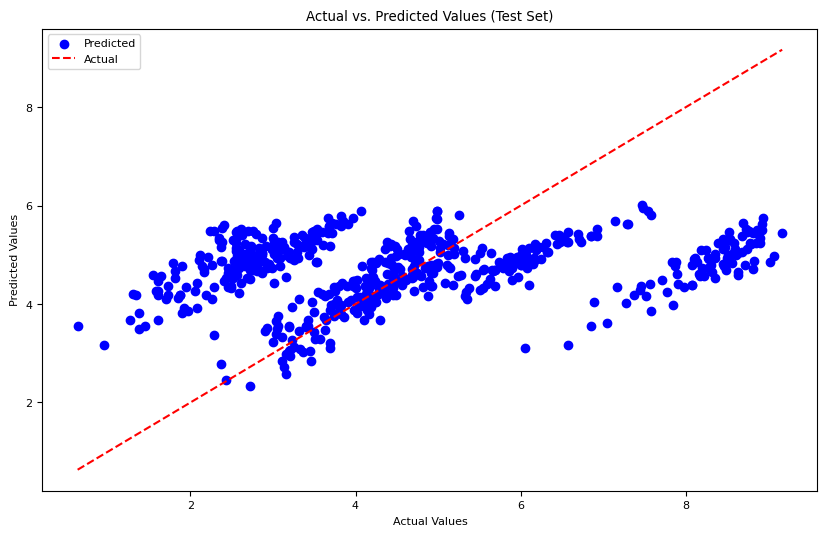

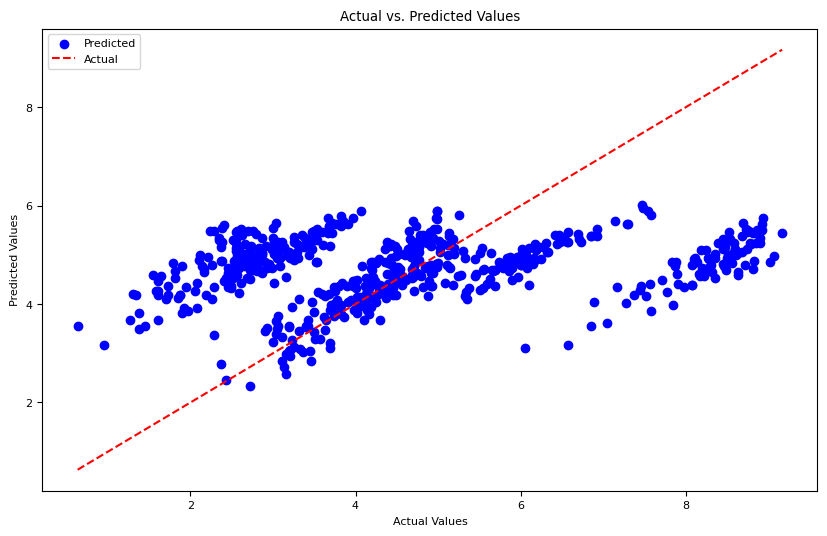

In [521]:
X = pre_data_ln.drop(columns=['ESTIMATE_sqrt','UNIT','IS_ADULT']) 
X = pd.get_dummies(X)
y = pre_data_ln['ESTIMATE_sqrt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25) #split

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
md_pred = model

#visualize
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted')  # 绘制预测值
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Actual')  # 绘制对角线（实际值）
plt.title('Actual vs. Predicted Values (Test Set)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

#model info
ln_pred_coeff = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
ln_pred_inter = model.intercept_
ln_pred_r2 = model.score(X, y)

## 7.3 Searching for Patterns

In [495]:
print(ts_info)

                               SARIMAX Results                                
Dep. Variable:          ESTIMATE_sqrt   No. Observations:                   10
Model:                 ARIMA(0, 2, 2)   Log Likelihood                   2.923
Date:                Fri, 03 May 2024   AIC                              0.154
Time:                        11:18:29   BIC                              0.392
Sample:                             0   HQIC                            -1.454
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2067      1.168     -0.177      0.860      -2.496       2.083
ma.L2         -0.0518      0.903     -0.057      0.954      -1.822       1.719
sigma2         0.0280      0.016      1.749      0.0

In [496]:
ln_cha_coeff.to_csv("cha_coeff.csv", index=False)
print("Coefficients:\n", ln_cha_coeff)
print("Intercept:", ln_cha_inter)
print("R^2 Score:", ln_cha_r2)

Coefficients:
                                               Feature   Coefficient
0                                                YEAR  3.659973e-02
1            UNIT_Percent of population, age-adjusted  1.628929e+10
2                   UNIT_Percent of population, crude  1.628929e+10
3                                     AGE_12-19 years  2.037712e+10
4                                      AGE_2-19 years  2.037712e+10
5                                       AGE_2-5 years  2.037712e+10
6                               AGE_20 years and over -1.180281e+10
7                                     AGE_20-34 years -1.703454e+10
8                                     AGE_35-44 years -1.590967e+10
9                                     AGE_45-54 years -1.781088e+10
10                                    AGE_55-64 years -1.457084e+10
11                                     AGE_6-11 years  2.037712e+10
12                                    AGE_65-74 years -1.428343e+10
13                              A

In [497]:
ln_pred_coeff.to_csv("pred_coeff.csv", index=False)
print("Coefficients:\n", ln_pred_coeff)
print("Intercept:", ln_pred_inter)
print("R^2 Score:", ln_pred_r2)

Coefficients:
                                               Feature   Coefficient
0                                                YEAR  3.272924e-02
1                                     AGE_12-19 years  5.177120e+11
2                                      AGE_2-19 years  5.177120e+11
3                                       AGE_2-5 years  5.177120e+11
4                               AGE_20 years and over  5.177120e+11
5                                     AGE_20-34 years  3.148059e+11
6                                     AGE_35-44 years  4.273390e+11
7                                     AGE_45-54 years  3.715750e+11
8                                     AGE_55-64 years  9.890282e+11
9                                      AGE_6-11 years  5.177120e+11
10                                    AGE_65-74 years  1.587438e+11
11                              AGE_75 years and over  2.808663e+11
12                 STUB_LABEL_Derive_Age: 12-19 years  8.637209e+10
13                   STUB_LABEL_D